In [1]:
import os
import cv2
import time
import json
import joblib
import pandas as pd
import numpy as np

import imageio
import tensorflow as tf
import librosa
import librosa.display
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

import keras
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
from keras.applications.mobilenet_v3 import MobileNetV3Large, preprocess_input

2024-02-20 20:14:22.379004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 20:14:22.687323: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 20:14:23.779625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bmarghescu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2024-02-20 20:14:23.779744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugi

In [2]:
DATASET_DIR = "Datasets/EMO-IIT_Separate_Speakers_v2/female"
SPECTROGRAM_DIR = "Spectrograms/EMO-IIT_Separate_Speakers_v2/female/Log"
TF_RECORDS_DIR = "TFRecords/EMO-IIT_Separate_Speakers_v2_female_MobileNetV3Large"
TF_RECORDS_NAME = "EMO-IIT_Separate_Speakers_v2_female_log_MobileNetV3Large.tfrecords"
MODEL_DIR = "Models"
MODEL_NAME = "EMO-IIT_Separate_Speakers_v2_female_log_MobileNetV3Large.h5"
NUM_CLASSES = 8
SAMPLE_RATE = 16000
BATCH_SIZE = 32
EPOCHS = 50
RANDOM_SEED = 42

In [3]:
def create_dataframe_emodb():
    EMOTION_DICT_EMODB = {'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'fear', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}
    if DATASET_DIR != "Datasets/EmoDB" and DATASET_DIR != "Datasets/Converted Datasets/EmoDB":
        raise Exception("DATASET_DIR must be set to 'Datasets/EmoDB' or 'Datasets/Converted Datasets/EmoDB' for EmoDB dataset")
    file_person, file_gender, file_emotion, file_path = [], [], [], []
    file_list = os.listdir(DATASET_DIR)
    for file in file_list:
        person = int(file[0:2])
        gender = 'male' if person in [3, 10, 11, 12, 15] else 'female'
        emotion = EMOTION_DICT_EMODB[file[5]]
        file_person.append(person)
        file_gender.append(gender)
        file_emotion.append(emotion)
        file_path.append(os.path.join(DATASET_DIR, file))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'path': file_path}
    emodb_df = pd.DataFrame(file_dict)
    return emodb_df

In [4]:
def create_dataframe_emoiit():
    if DATASET_DIR != "Datasets/EMO-IIT" and DATASET_DIR != "Datasets/Converted Datasets/EMO-IIT":
        raise Exception("DATASET_DIR must be set to 'Datasets/EMO-IIT' or 'Datasets/Converted Datasets/EMO-IIT' for EMO-IIT dataset")
    file_emotion, file_path = [], []
    emotion_dir_list = os.listdir(DATASET_DIR)
    for emotion_dir in emotion_dir_list:
        file_list = os.listdir(os.path.join(DATASET_DIR, emotion_dir))
        for file in file_list:
            if file.endswith('.wav'):
                file_emotion.append(emotion_dir)
                file_path.append(os.path.join(DATASET_DIR, emotion_dir, file))
    file_dict = {'emotion': file_emotion, 'path': file_path}
    emoiit_df = pd.DataFrame(file_dict)
    emoiit_df = pd.DataFrame(shuffle(emoiit_df, random_state=RANDOM_SEED), columns=emoiit_df.columns).reset_index(drop=True, inplace=False)
    return emoiit_df

In [5]:
def create_dataframe_emoiit_separate_speakers_gendered():
    file_emotion, file_speaker_id, file_path = [], [], []
    for emotion_dir in os.listdir(DATASET_DIR):
        for file in os.listdir(os.path.join(DATASET_DIR, emotion_dir)):
            if file.endswith(".wav"):
                speaker_id = file[:5] if file[:4].lower() == "b511" else file[:4].lower()
                file_emotion.append(emotion_dir)
                file_speaker_id.append(speaker_id)
                file_path.append(os.path.join(DATASET_DIR, emotion_dir, file))
    emoiit_df = pd.DataFrame({'emotion': file_emotion, 'speaker_id': file_speaker_id, 'path': file_path}).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    common_speakers = set.intersection(*[set(emoiit_df[emoiit_df['emotion'] == emotion]['speaker_id'].unique()) for emotion in emoiit_df['emotion'].unique() if emotion != 'irritation'])
    common_speakers_list = list(common_speakers)
    emoiit_df_common_speakers = emoiit_df[emoiit_df['speaker_id'].isin(common_speakers_list)]
    emoiit_df_common_speakers_dict = {speaker: emoiit_df_common_speakers[emoiit_df_common_speakers['speaker_id'] == speaker].reset_index(drop=True) for speaker in common_speakers_list}
    emoiit_df_irritation = emoiit_df[emoiit_df['emotion'] == 'irritation'].sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    num_parts = len(common_speakers_list)
    emoiit_df_irritation_parts = [emoiit_df_irritation[i:i + len(emoiit_df_irritation) // num_parts] for i in range(0, len(emoiit_df_irritation), len(emoiit_df_irritation) // num_parts)]
    return [pd.concat([emoiit_df_common_speakers_dict[common_speakers_list[i]], emoiit_df_irritation_parts[i]], ignore_index=True) for i in range(len(common_speakers_list))]

In [6]:
def create_dataframe_ravdess():
    emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    if DATASET_DIR != "Datasets/RAVDESS/audio_speech_actors_01-24" and DATASET_DIR != "Datasets/Converted Datasets/RAVDESS":
        raise Exception("DATASET_DIR must be set to 'Datasets/RAVDESS/audio_speech_actors_01-24' or 'Datasets/Converted Datasets/RAVDESS' for RAVDESS dataset")
    file_person, file_gender, file_emotion, file_intensity, file_path = [], [], [], [], []
    person_dir_list = os.listdir(DATASET_DIR)
    for person_dir in person_dir_list:
        if person_dir.startswith("Actor_"):
            person = int(person_dir.split("_")[1])
            file_list_person = os.listdir(os.path.join(DATASET_DIR, person_dir))
            for file in file_list_person:
                if file.endswith(".wav"):
                    file_person.append(person)
                    file_path.append(os.path.join(DATASET_DIR, person_dir, file))
                    file_gender.append("male" if person % 2 == 1 else "female")
                    file_emotion.append(emotion_list[int(file.split("-")[2]) - 1])
                    file_intensity.append(int(file.split("-")[3].split(".")[0]))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'intensity': file_intensity, 'path': file_path}
    ravdess_df = pd.DataFrame(file_dict)
    ravdess_df = pd.DataFrame(shuffle(ravdess_df, random_state=RANDOM_SEED), columns=ravdess_df.columns).reset_index(drop=True, inplace=False)
    return ravdess_df

In [7]:
def preprocess_dataset(ser_df, dataset_type, ohe=None, fold=None):
    audio_block_list = []
    emotion_list = []
    for row in tqdm(ser_df.itertuples(), desc=f"Preprocessing audio files dataset - {dataset_type}", total=len(ser_df)):
        data, _ = librosa.load(row.path, sr=SAMPLE_RATE)
        if data.shape[0] < SAMPLE_RATE:
            data = np.pad(data, (0, SAMPLE_RATE - data.shape[0]), 'constant')
        frames = librosa.util.frame(data, frame_length=SAMPLE_RATE, hop_length=int(SAMPLE_RATE/100)).T
        for frame in frames:
            audio_block_list.append(frame)
            emotion_list.append(row.emotion)
    audio_block_list = np.array(audio_block_list)
    emotion_list = np.array(emotion_list)
    if ohe is None:
        ohe = OneHotEncoder(categories='auto', sparse=False)
        emotion_list = ohe.fit_transform(emotion_list[:, np.newaxis])
        ohe_path = os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_fold_{fold + 1}_ohe.pkl")) if fold is not None else os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", "_ohe.pkl"))
        joblib.dump(ohe, ohe_path)
    else:
        emotion_list = ohe.transform(emotion_list[:, np.newaxis])
    return audio_block_list, emotion_list

In [8]:
def create_spectrogram_log(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    Xdb = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(Xdb))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [9]:
def create_spectrogram_linear(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=np.amin(X), vmax=np.amax(X))
    image = cmap(norm(X))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [10]:
def create_spectrogram_mel(data, sr):
    Xmel = np.abs(librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    X_mel_db = librosa.amplitude_to_db(Xmel, ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(X_mel_db))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [11]:
def create_spectrogram_hpss(data, sr):
    X = librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4))
    X_harmonic, X_percussive = librosa.decompose.hpss(X)
    X_db = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    X_harmonic_db = librosa.amplitude_to_db(np.abs(X_harmonic), ref=np.max)
    X_percussive_db = librosa.amplitude_to_db(np.abs(X_percussive), ref=np.max)
    image = np.hstack((X_db, X_harmonic_db, X_percussive_db))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(image))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [12]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_png(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [13]:
def create_example_train(image, path, emotion_id):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [14]:
def create_example_test(image, path, emotion_id, sample_weight):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
        "sample_weight": float_feature(sample_weight),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [15]:
def parse_tfrecord_train(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example


def parse_tfrecord_test(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
        "sample_weight": tf.io.FixedLenFeature([1], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example

In [16]:
def create_spectrogram_dataset(audio_block_list, emotion_list, tf_records_name, spectrogram_dir, sr, create_spectrogram, sample_weight=None, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    if not os.path.exists(os.path.join(TF_RECORDS_DIR, dataset_type)):
        os.makedirs(os.path.join(TF_RECORDS_DIR, dataset_type))
    with tf.io.TFRecordWriter(os.path.join(TF_RECORDS_DIR, dataset_type, tf_records_name)) as writer:
        for index, block in enumerate(tqdm(audio_block_list, desc=f"Creating Spectrogram Dataset - {dataset_type}", total=audio_block_list.shape[0])):
            image = create_spectrogram(block, sr)
            if not os.path.exists(os.path.join(spectrogram_dir, dataset_type)):
                os.makedirs(os.path.join(spectrogram_dir, dataset_type))
            image_path = os.path.join(spectrogram_dir, dataset_type, f"{index:05d}.png")
            imageio.imsave(image_path, image)
            image = tf.io.decode_png(tf.io.read_file(image_path))
            if dataset_type == "train":
                example = create_example_train(image, image_path, emotion_list[index])
            else:
                if sample_weight is None:
                    raise ValueError("sample_weight must be provided for test dataset")
                else:
                    example = create_example_test(image, image_path, emotion_list[index], np.expand_dims(sample_weight[index], axis=0))
            writer.write(example.SerializeToString())

In [17]:
def prepare_sample_train(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    return image, features["emotion_id"]


def prepare_sample_test(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    sample_weight = tf.squeeze(features["sample_weight"])
    return image, features["emotion_id"], sample_weight

In [18]:
def get_dataset(filename, batch_size, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    AUTOTUNE = tf.data.AUTOTUNE
    if dataset_type == "train":
        dataset = (
            tf.data.TFRecordDataset(filename, num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_train, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_train, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    else:
        dataset = (
            tf.data.TFRecordDataset(filename, num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_test, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_test, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    return dataset

In [19]:
def create_ser_model():
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        # vgg16 = VGG16(weights="imagenet")
        # model = Model(inputs=vgg16.input, outputs=Dense(NUM_CLASSES, activation="softmax", name="emotion")(vgg16.get_layer("fc2").output))
        mobilenetv3_large = MobileNetV3Large(weights="imagenet")
        model = Model(inputs=mobilenetv3_large.input, outputs=Dense(NUM_CLASSES, activation="softmax", name="emotion")(mobilenetv3_large.layers[-2].output))
        optimizer = tf.optimizers.SGD(learning_rate=0.0001, decay=0.0001, momentum=0.9)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
        return model

In [20]:
def plot_history(history, model_name):
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))
    fig.suptitle(model_name, size=20)
    axs[0].plot(history.history['loss'])
    axs[0].title.set_text('Training Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[1].plot(history.history['accuracy'])
    axs[1].title.set_text('Training Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    plt.show()

In [21]:
def plot_training_curve(model_name):
    history_json = json.load(open(os.path.join(MODEL_DIR, model_name.replace(".h5", ".json")), "r"))
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['weighted_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Weighted Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [22]:
def get_run_logdir(root_logdir):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [23]:
ser_df_parts = create_dataframe_emoiit_separate_speakers_gendered()
# strategy = tf.distribute.MirroredStrategy()
# num_gpus = strategy.num_replicas_in_sync


Fold 1:


Preprocessing audio files dataset - test: 100%|██████████| 30/30 [00:00<00:00, 67.74it/s]
2024-02-20 20:14:35.199930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-20 20:14:35.201585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-20 20:14:35.203047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-20 20:14:35.204482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-20 20:14:35.218287: I 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

2024-02-20 20:15:03.625032: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-02-20 20:15:04.230604: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-02-20 20:15:05.122245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2024-02-20 20:15:05.802807: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301


27/27 [==============================] - 20s 94ms/step - loss: 0.0180 - accuracy: 0.9942 - weighted_accuracy: 0.9929
FOLD 1: Test accuracy: 99.42%
Test weighted accuracy: 99.29%
Test loss: 0.01800592429935932


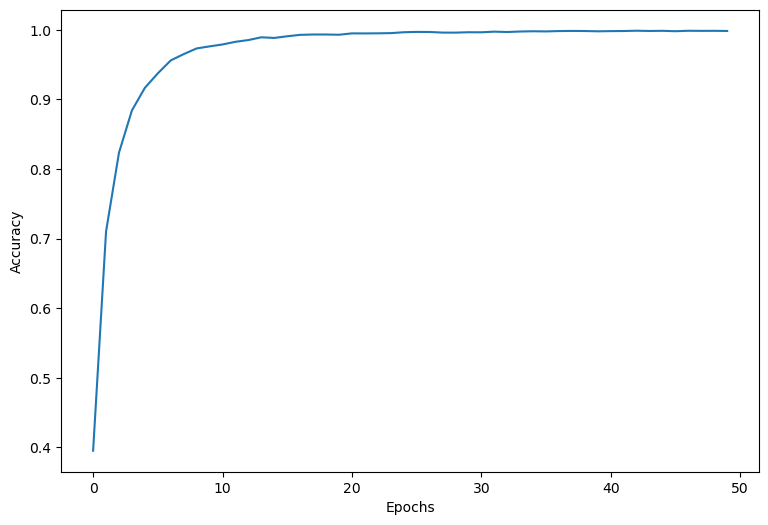

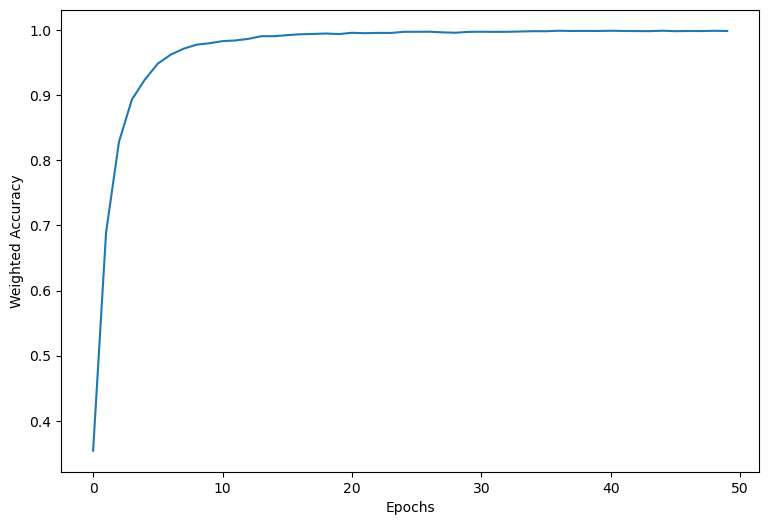

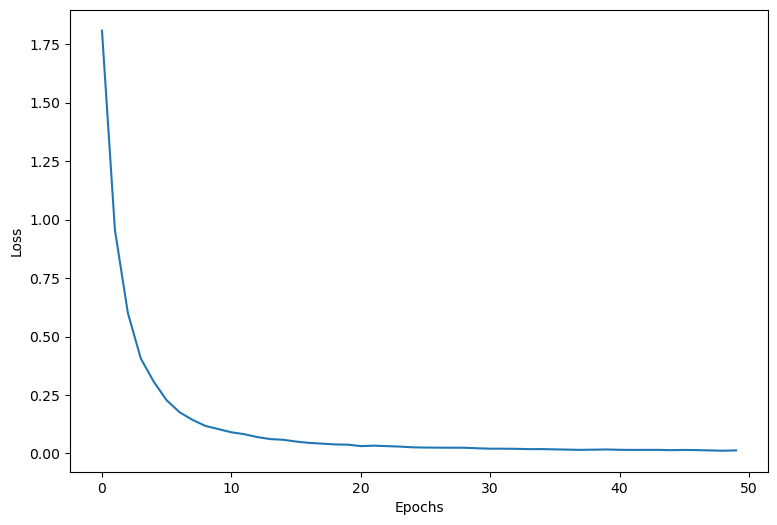

Getting predictions for test set: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


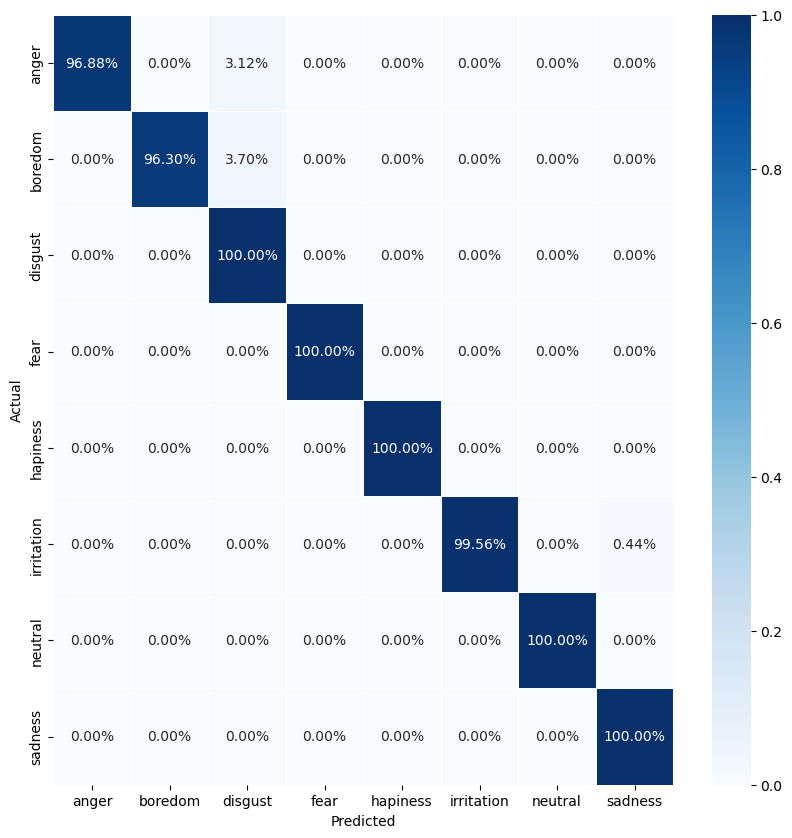


Fold 2:


Preprocessing audio files dataset - test: 100%|██████████| 58/58 [00:00<00:00, 103.84it/s]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


46/46 [==============================] - 13s 65ms/step - loss: 0.0187 - accuracy: 0.9884 - weighted_accuracy: 0.9950
FOLD 2: Test accuracy: 98.84%
Test weighted accuracy: 99.50%
Test loss: 0.01866995543241501


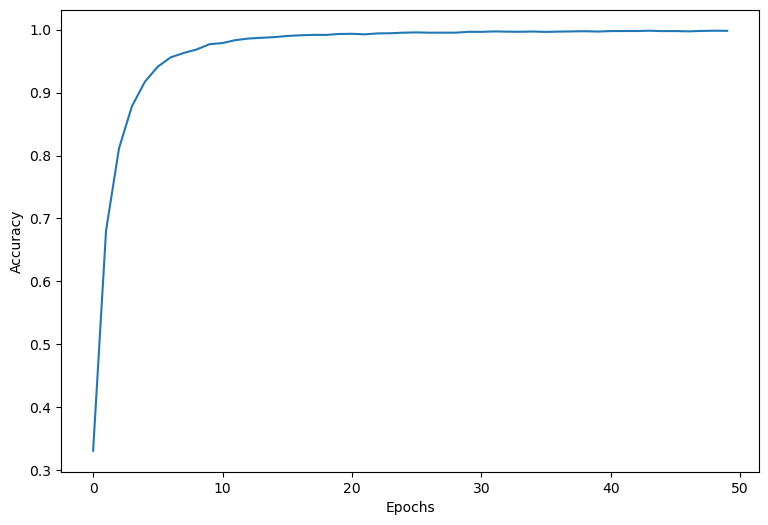

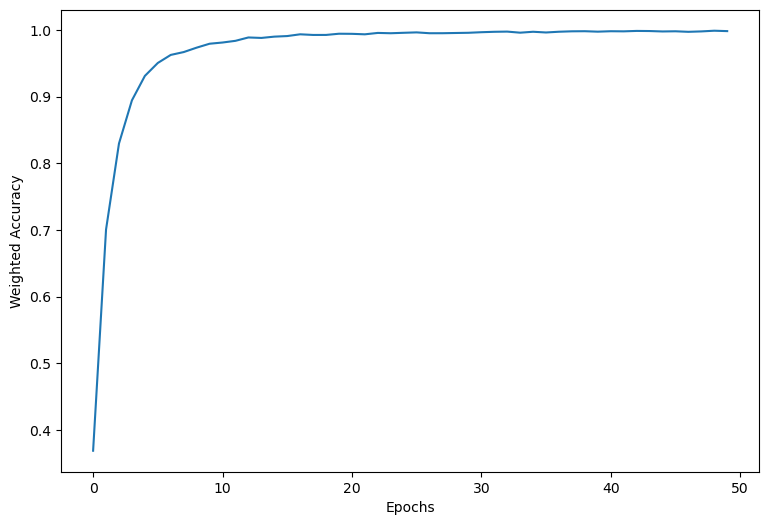

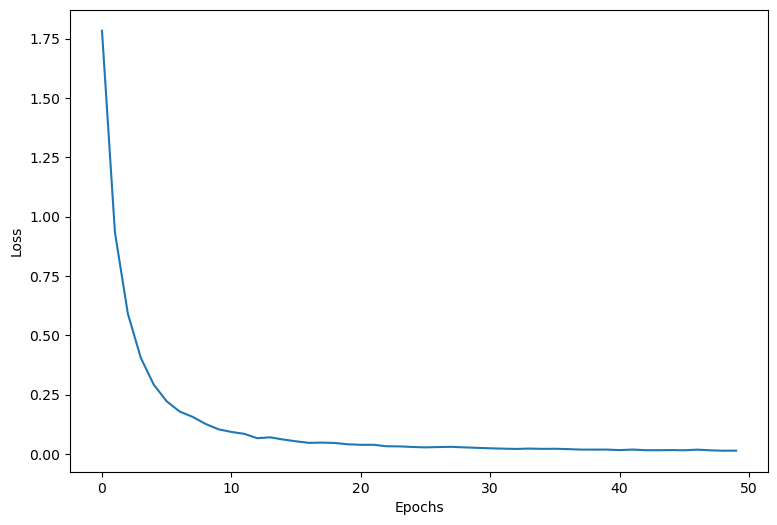

Getting predictions for test set: 100%|██████████| 46/46 [00:41<00:00,  1.11it/s]


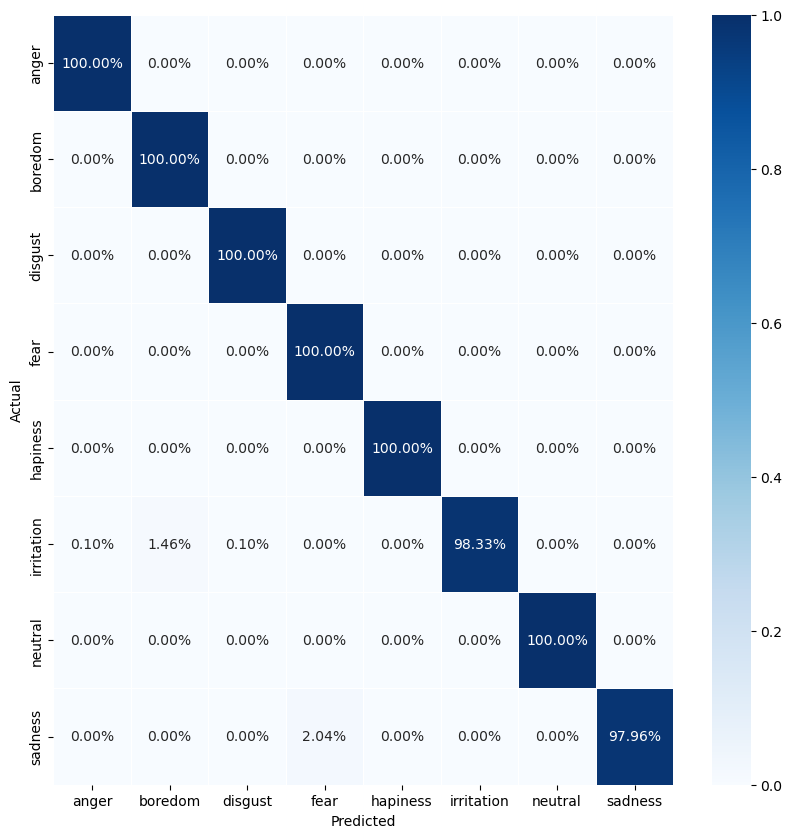


Fold 3:


Preprocessing audio files dataset - test: 100%|██████████| 29/29 [00:00<00:00, 35.52it/s]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


49/49 [==============================] - 13s 51ms/step - loss: 0.0223 - accuracy: 0.9858 - weighted_accuracy: 0.9856
FOLD 3: Test accuracy: 98.58%
Test weighted accuracy: 98.56%
Test loss: 0.022289760410785675


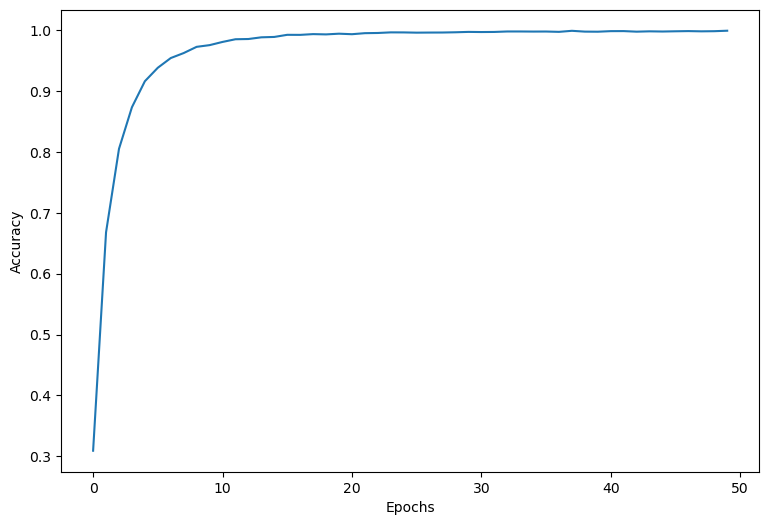

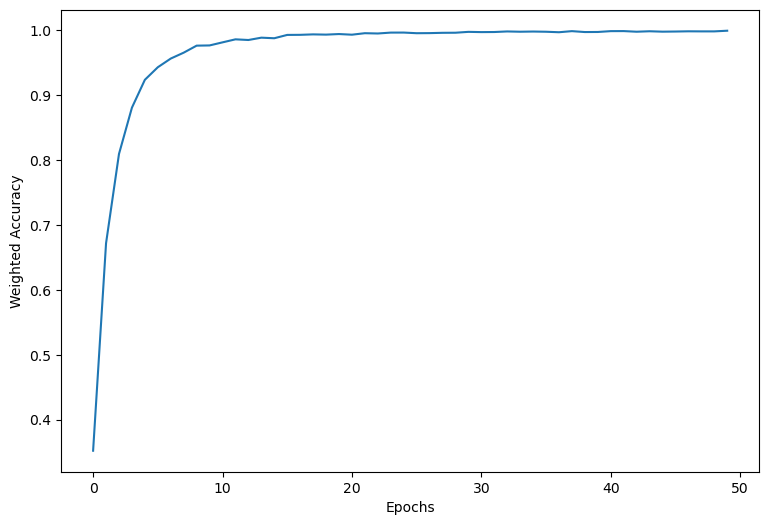

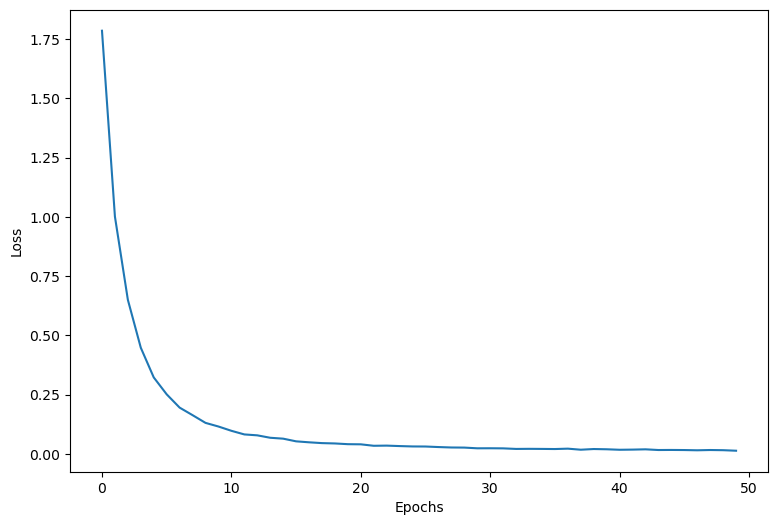

Getting predictions for test set: 100%|██████████| 49/49 [00:44<00:00,  1.11it/s]


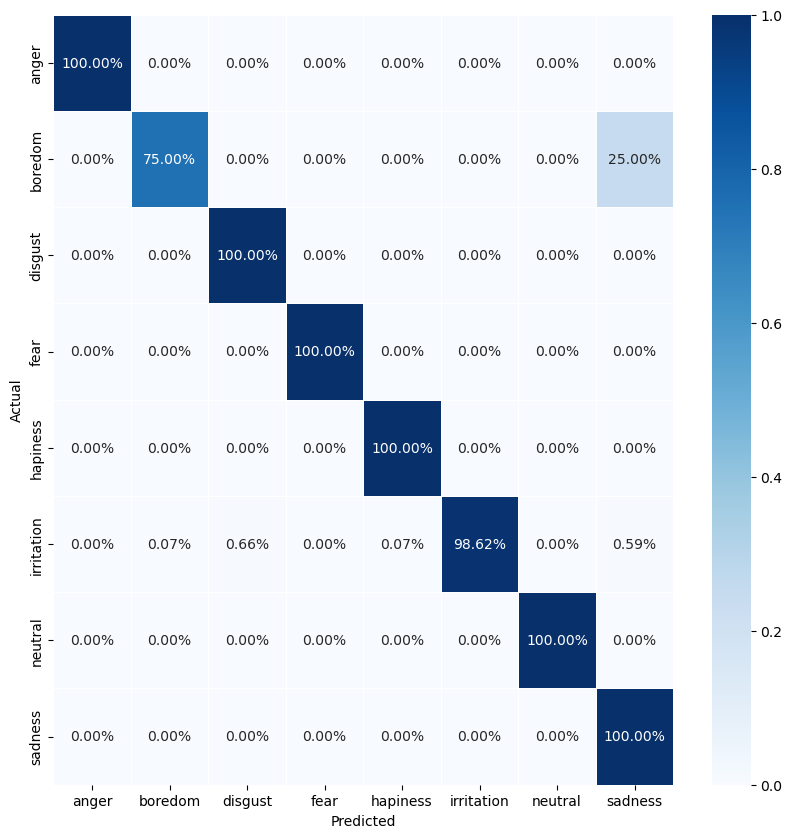


Fold 4:


Preprocessing audio files dataset - test: 100%|██████████| 56/56 [00:00<00:00, 79.49it/s]


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
68/68 [==============================] - 15s 59ms/step - loss: 0.0112 - accuracy: 0.9935 - weighted_accuracy: 0.9978
FOLD 4: Test accuracy: 99.35%
Test weighted accuracy: 99.78%
Test loss: 0.011155526153743267


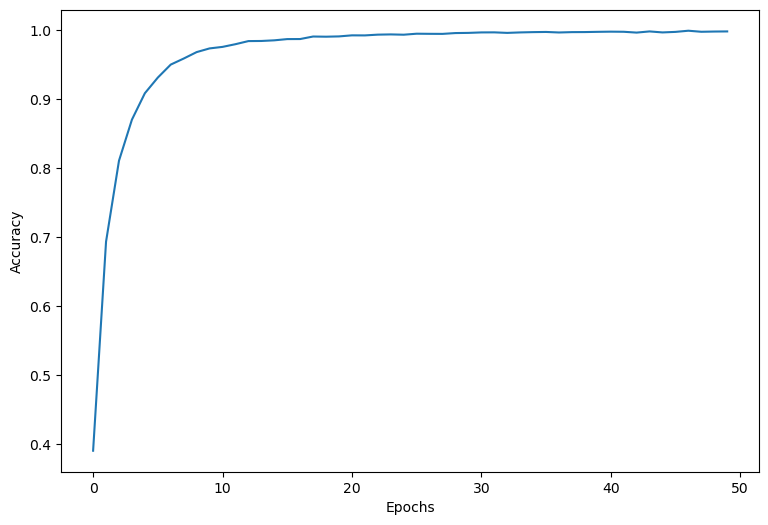

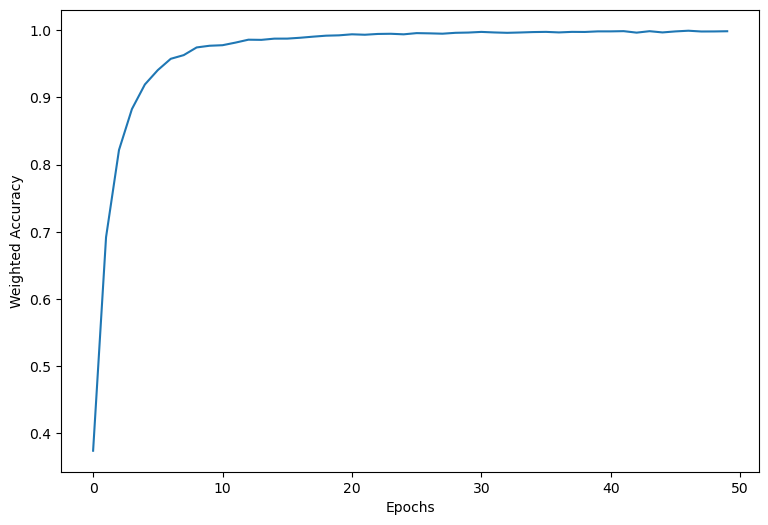

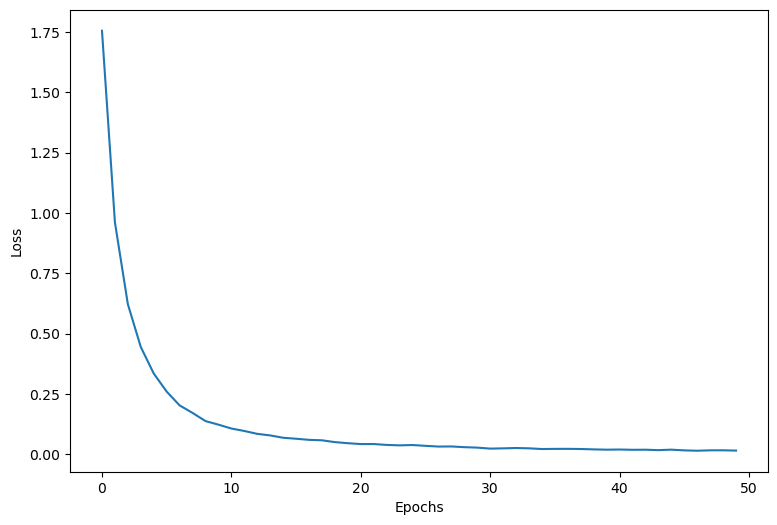

Getting predictions for test set: 100%|██████████| 68/68 [00:51<00:00,  1.32it/s]


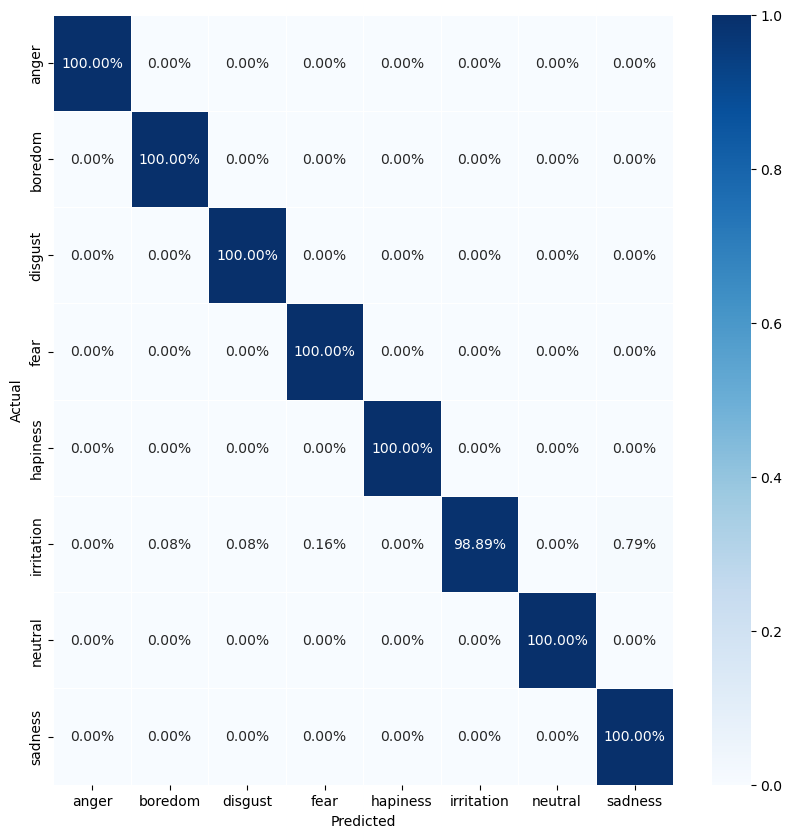


Fold 5:


Preprocessing audio files dataset - test: 100%|██████████| 30/30 [00:00<00:00, 80.13it/s] 


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
57/57 [==============================] - 15s 52ms/step - loss: 0.0111 - accuracy: 0.9873 - weighted_accuracy: 0.9977
FOLD 5: Test accuracy: 98.73%
Test weighted accuracy: 99.77%
Test loss: 0.011122315190732479


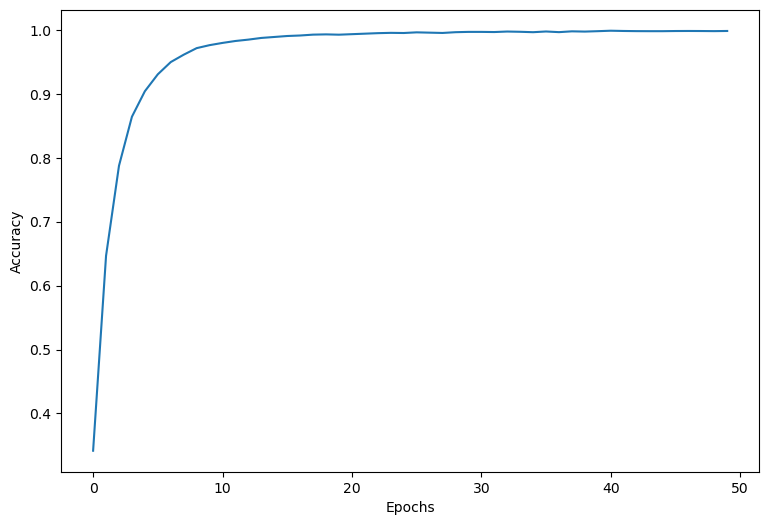

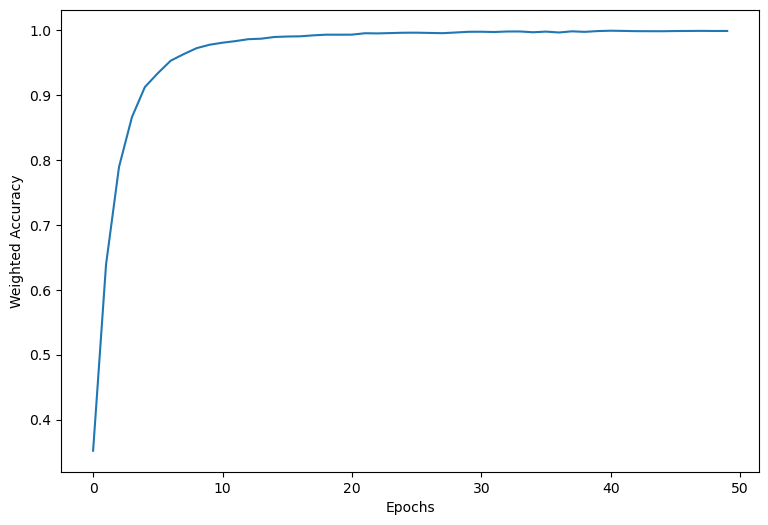

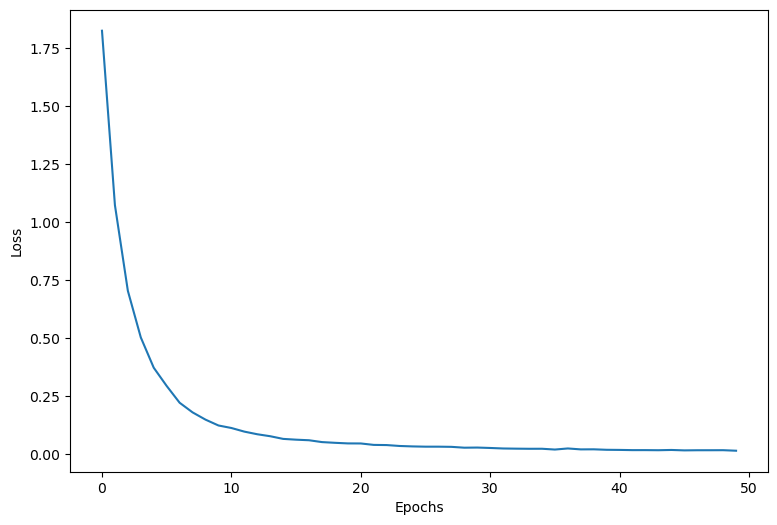

Getting predictions for test set: 100%|██████████| 57/57 [00:44<00:00,  1.27it/s]


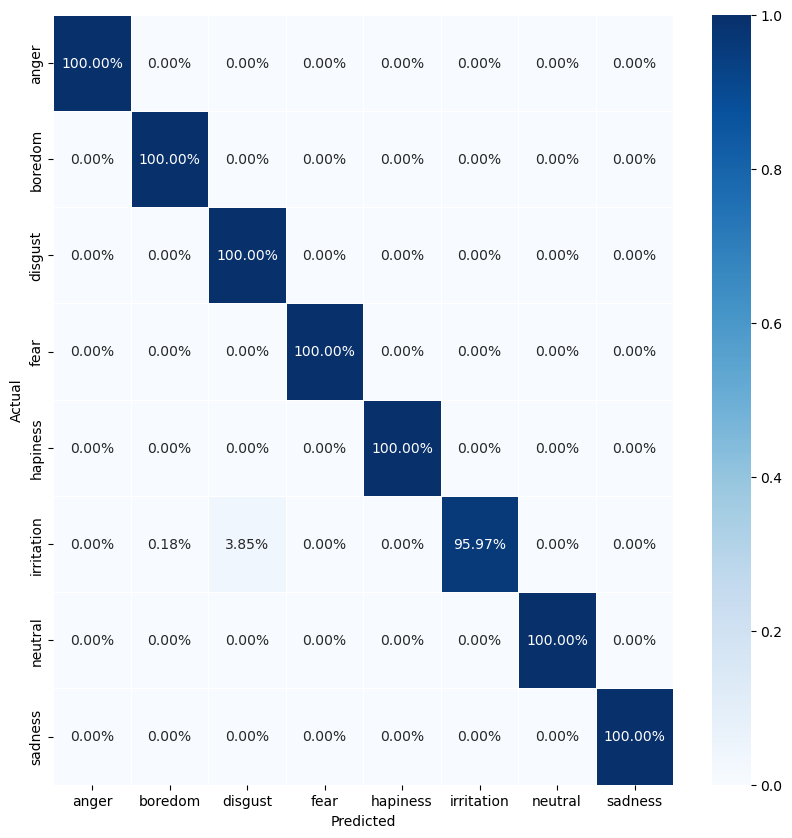


Fold 6:


Preprocessing audio files dataset - test: 100%|██████████| 28/28 [00:00<00:00, 86.45it/s] 


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
114/114 [==============================] - 18s 51ms/step - loss: 0.0051 - accuracy: 0.9992 - weighted_accuracy: 0.9999
FOLD 6: Test accuracy: 99.92%
Test weighted accuracy: 99.99%
Test loss: 0.0050783236511051655


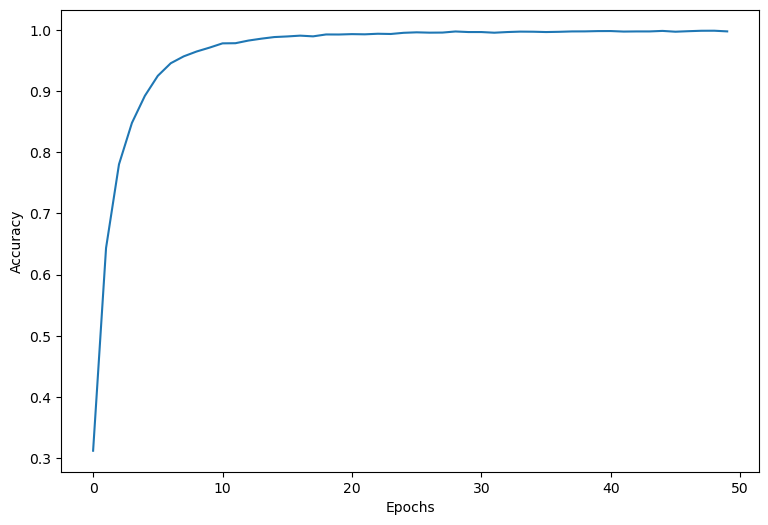

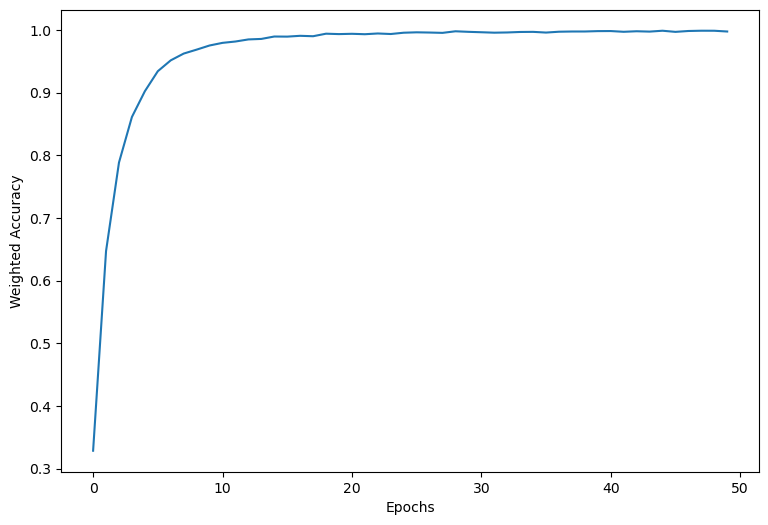

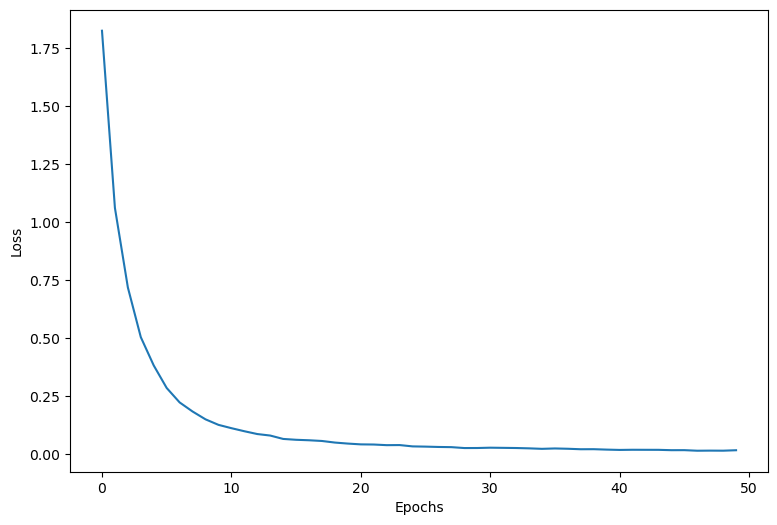

Getting predictions for test set: 100%|██████████| 114/114 [01:11<00:00,  1.60it/s]


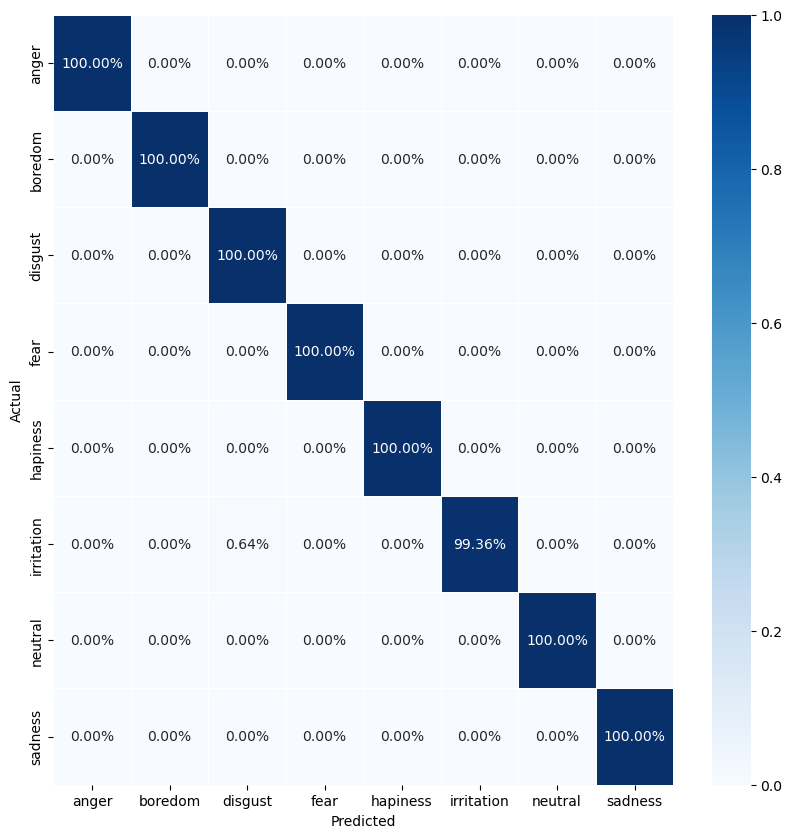


Fold 7:


Preprocessing audio files dataset - test: 100%|██████████| 29/29 [00:00<00:00, 224.40it/s]


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
18/18 [==============================] - 12s 86ms/step - loss: 0.0242 - accuracy: 0.9982 - weighted_accuracy: 0.9985
FOLD 7: Test accuracy: 99.82%
Test weighted accuracy: 99.85%
Test loss: 0.024182206019759178


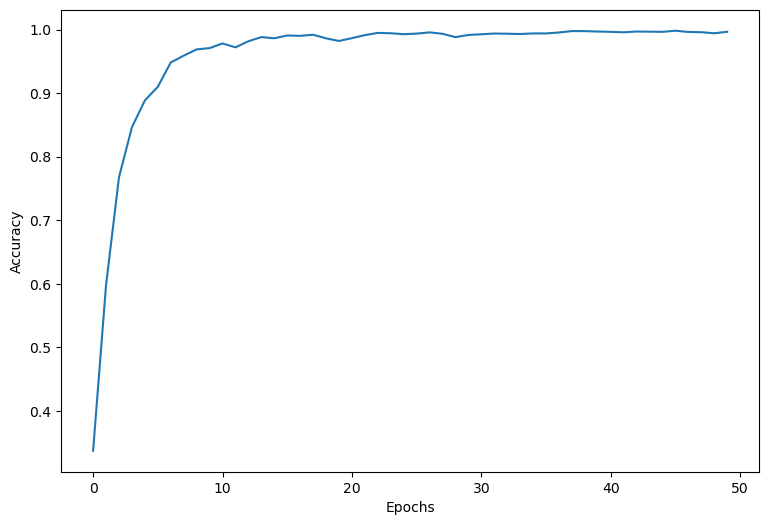

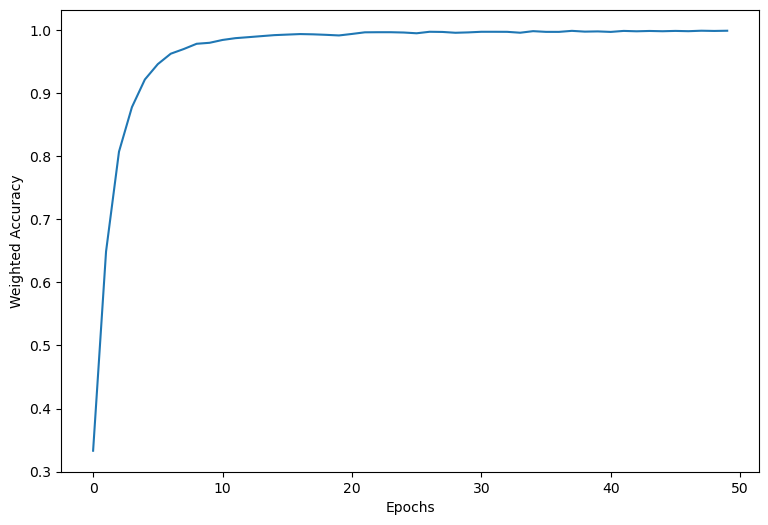

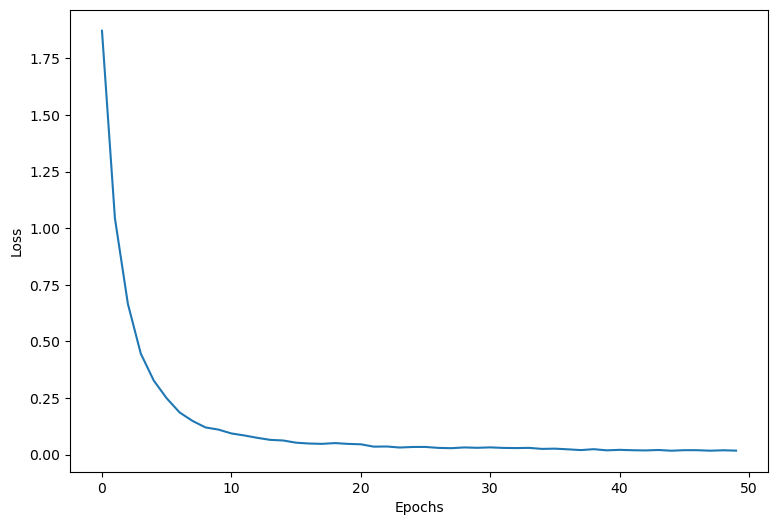

Getting predictions for test set: 100%|██████████| 18/18 [00:30<00:00,  1.67s/it]


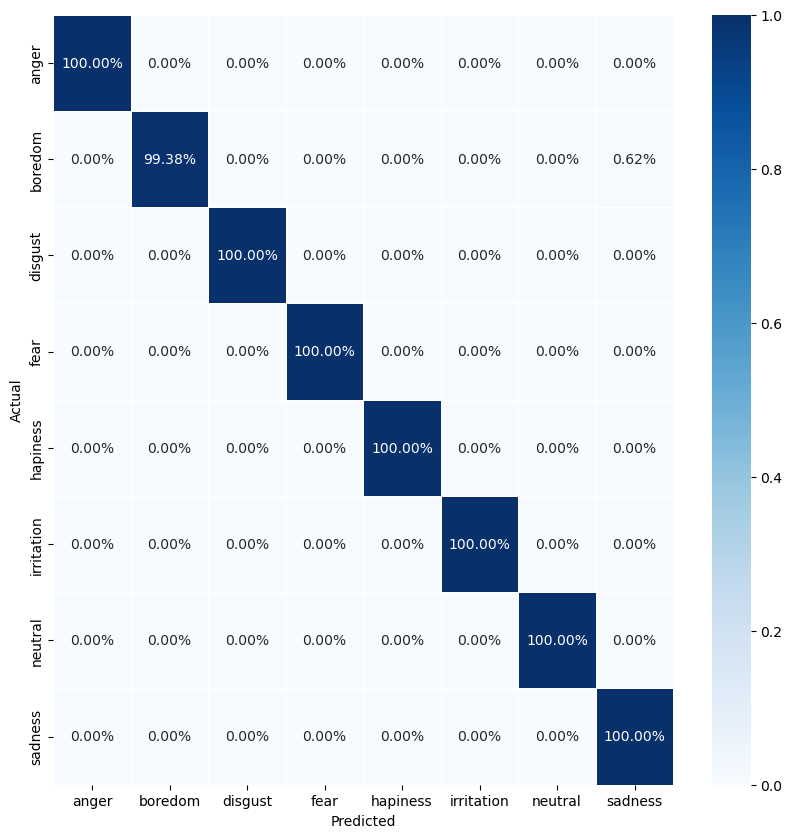


Fold 8:


Preprocessing audio files dataset - test: 100%|██████████| 23/23 [00:00<00:00, 52.66it/s] 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


43/43 [==============================] - 15s 53ms/step - loss: 0.0301 - accuracy: 0.9764 - weighted_accuracy: 0.9919
FOLD 8: Test accuracy: 97.64%
Test weighted accuracy: 99.19%
Test loss: 0.030113477259874344


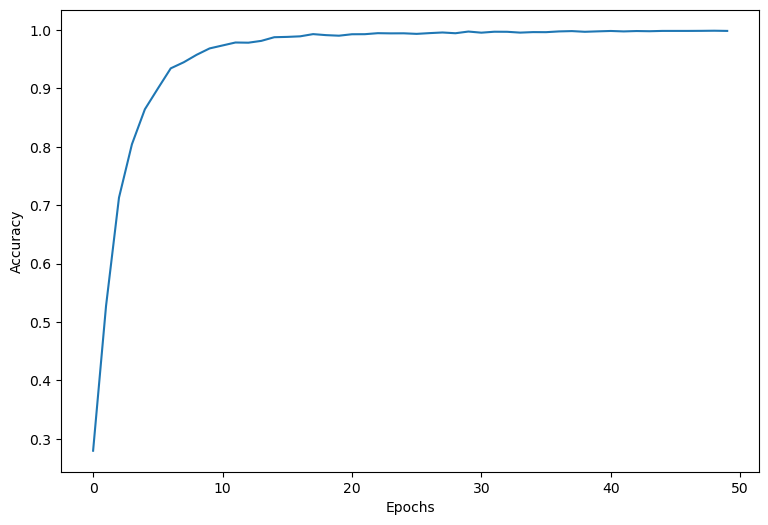

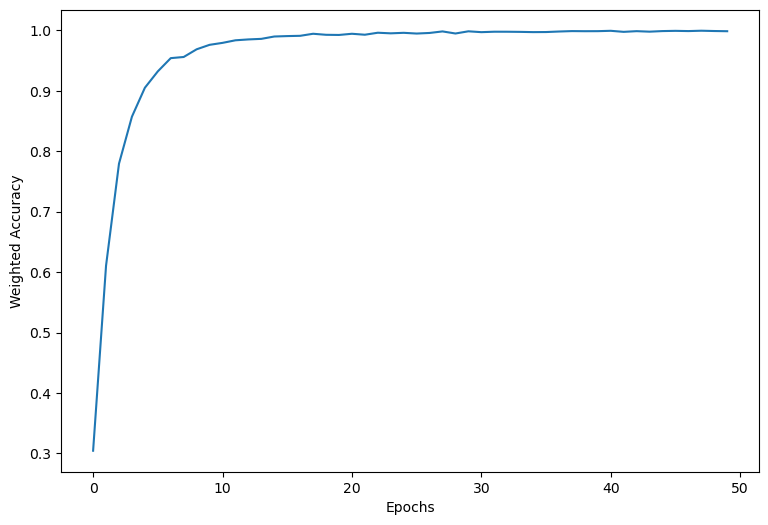

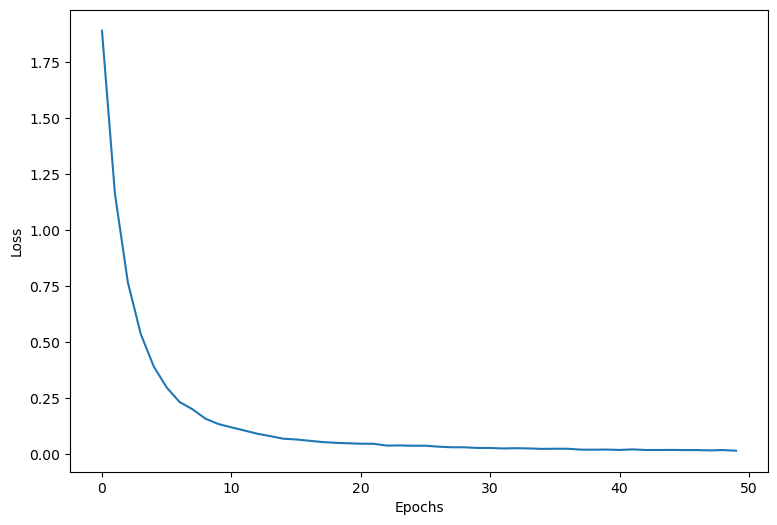

Getting predictions for test set: 100%|██████████| 43/43 [00:37<00:00,  1.14it/s]


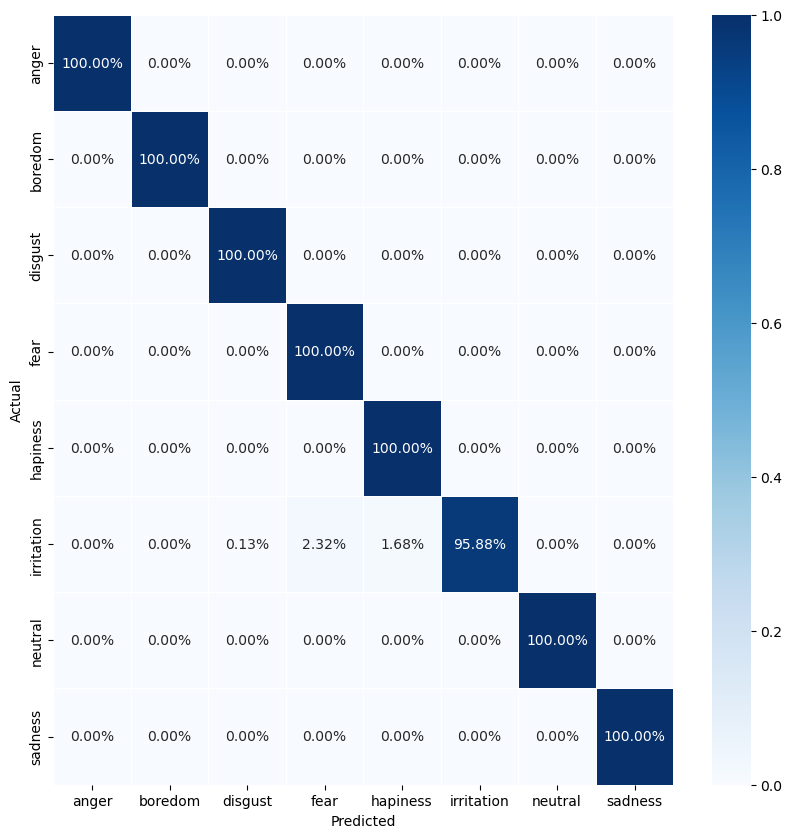

In [24]:
FOLD_TO_TRAIN = 99 # Change this to train on a specific fold from 0 to 4
test_cv_results = []
for fold, test_df in enumerate(ser_df_parts):
    print(f"\nFold {fold + 1}:")
    train_dfs = [df for idx, df in enumerate(ser_df_parts) if idx != fold]
    train_df = pd.concat(train_dfs).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    audio_block_list_train, emotion_list_train = preprocess_dataset(train_df, "train", fold=fold)
    ohe = joblib.load(os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_fold_{fold + 1}_ohe.pkl")))
    audio_block_list_test, emotion_list_test = preprocess_dataset(test_df, "test", ohe=ohe, fold=fold)
    cls_weight = class_weight.compute_class_weight(class_weight='balanced', classes=ohe.categories_[0], y=ohe.inverse_transform(emotion_list_train).flatten())
    cls_weight_dict = dict(zip(ohe.categories_[0], cls_weight))
    test_sample_weight = class_weight.compute_sample_weight(class_weight=cls_weight_dict, y=ohe.inverse_transform(emotion_list_test).flatten())
    new_spectrogram_dir = SPECTROGRAM_DIR + f"_fold_{fold + 1}"
    new_model_name = MODEL_NAME.replace(".h5", f"_fold_{fold + 1}.h5")
    new_tfrecords_name = TF_RECORDS_NAME.replace(".tfrecords", f"_fold_{fold + 1}.tfrecords")
    # train_dataset = get_dataset(os.path.join(TF_RECORDS_DIR, "train", new_tfrecords_name), BATCH_SIZE * num_gpus, dataset_type="train")
    test_dataset = get_dataset(os.path.join(TF_RECORDS_DIR, "test", new_tfrecords_name), BATCH_SIZE, dataset_type="test")
    if fold == FOLD_TO_TRAIN:
        if not os.path.exists(MODEL_DIR):
            os.makedirs(MODEL_DIR)
        model = create_ser_model()
        run_logdir = get_run_logdir(root_logdir=os.path.join(os.curdir, "Logs", new_model_name.replace(".h5", "")))
        tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
        checkpoint = ModelCheckpoint(os.path.join(MODEL_DIR, new_model_name), verbose=1, monitor='accuracy', save_best_only=True, mode='auto')
        history = model.fit(x=train_dataset, class_weight=dict(enumerate(cls_weight)), epochs=EPOCHS, verbose=1, callbacks=[tensorboard_cb, checkpoint], shuffle=False, workers=8, use_multiprocessing=True)
        json.dump(history.history, open(os.path.join(MODEL_DIR, new_model_name.replace(".h5", ".json")), "w"))
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = load_model(os.path.join(MODEL_DIR, new_model_name))
        results_test = model.evaluate(test_dataset, workers=12, use_multiprocessing=True)
        test_cv_results.append(results_test)
        print(f"FOLD {fold + 1}: Test accuracy: {results_test[1]:0.2%}\nTest weighted accuracy: {results_test[2]:0.2%}\nTest loss: {results_test[0]}")
        plot_training_curve(new_model_name)
        # plot confusion matrix
        test_dataset_slices = list(test_dataset.as_numpy_iterator())
        x_true = np.concatenate([batch[0] for batch in test_dataset_slices], axis=0)
        y_true = np.concatenate([batch[1] for batch in test_dataset_slices], axis=0)
        test_sample_weight = np.concatenate([batch[2] for batch in test_dataset_slices], axis=0)
        for i in tqdm(range(0, x_true.shape[0], BATCH_SIZE), desc="Getting predictions for test set"):
            if i == 0:
                y_pred = model.predict(x_true[i:i+BATCH_SIZE], verbose=0)
            else:
                y_pred = np.concatenate((y_pred, model.predict(x_true[i:i+BATCH_SIZE], verbose=0)), axis=0)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_true, axis=1)
        confusion_mat = confusion_matrix(y_true, y_pred, normalize="true")
        plt.figure(figsize=(10, 10))
        sns.heatmap(confusion_mat, annot=True, fmt=".2%", xticklabels=ohe.categories_[0], yticklabels=ohe.categories_[0], cmap="Blues", linewidths=0.5)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

In [25]:
# Print the average results of the 5 folds
print(f"Average results of the 5 folds:")
print(f"Test accuracy: {np.mean([result[1] for result in test_cv_results]):0.2%}")
print(f"Test weighted accuracy: {np.mean([result[2] for result in test_cv_results]):0.2%}")
print(f"Test loss: {np.mean([result[0] for result in test_cv_results])}")

Average results of the 5 folds:
Test accuracy: 99.04%
Test weighted accuracy: 99.49%
Test loss: 0.017577186052221805
